<a href="https://colab.research.google.com/github/andres-tovar-purdue/materials/blob/main/GP_vs_HGP_1D_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

White, G.M., A.P. Siegel, and A. Tovar. Optimizing Thermoplastic Starch Film with Heteroscedastic Gaussian Processes in a Bayesian Experimental Design Framework. *Materials*, Special Issue: Modelling, Simulation and Optimisation of Non-typical and Innovative Materials, 2024.

**Section 2.7: Numerical Example.** Comparison of heteroscedatic Gaussian process regression vs. traditional Gaussian process regression in a one-dimensional function.

In [1]:
!pip install gpflow==2.9.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 5.0 MB/s eta 0:00:00


In [2]:
import tensorflow
import gpflow
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

In [3]:
# Vanilla GP model
def train_gp_model(X, y, k='m32'):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    return model

def train_gp2_model(X, y, k='m32', lambda_=1e-3):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    model.likelihood.variance.assign(lambda_)
    gpflow.set_trainable(model.likelihood.variance, False)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, variables=model.trainable_variables)
    return model

def train_pgp_model(X, y, k='m32'):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    # kernel = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(), period=0.3)
    # kernel = gpflow.kernels.Periodic(gpflow.kernels.Matern32())
    kernel = gpflow.kernels.Periodic(kernel)
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    return model

def train_pgp2_model(X, y, k='m32', lambda_=1e-3):
    if k == 'm32':
      kernel = gpflow.kernels.Matern32()
    elif k == 'm52':
      kernel = gpflow.kernels.Matern52()
    elif k == 'rbf':
      kernel = gpflow.kernels.RBF()
    elif k == 'sqex':
      kernel = gpflow.kernels.SquaredExponential()
    elif k == 'linear':
      kernel = gpflow.kernels.Linear()
    elif k == 'white':
      kernel = gpflow.kernels.White()
    else:
      raise ValueError("Invalid kernel type. Must be 'm32', 'm52', 'rbf', 'sqex', 'linear, or 'white'.")
    # kernel = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(), period=0.3)
    # kernel = gpflow.kernels.Periodic(gpflow.kernels.Matern32())
    kernel = gpflow.kernels.Periodic(kernel)
    model = gpflow.models.GPR(data=(X, y), kernel=kernel, mean_function=None)
    model.likelihood.variance.assign(lambda_)
    gpflow.set_trainable(model.likelihood.variance, False)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    return model


In [4]:
# Function to calculate y based on the Forrester function
def calculate_y_true(x):
    return (6 * x - 2) ** 2 * np.sin(12 * x - 4)

def noise_var_fun(x):
  return 10*(x - 0.3)**2

def calculate_y_noisy(x):
    true_value = calculate_y_true(x)
    noise_variance = noise_var_fun(x)
    noise_value = np.random.normal(0, np.sqrt(noise_variance), x.shape)
    return true_value + noise_value

def noise_var_fun2(x, f=1):
  return np.abs(np.sin(2*np.pi*f*x))

def calculate_y_noisy2(x, gp_var=10):
    term1 = calculate_y_true(x) + np.random.normal(0, np.sqrt(gp_var), x.shape)
    return term1

In [5]:
def gp_plot(x_plot, y_true, y_mean, y_var, x_scatter, y_scatter, scale=1):
  # Plotting
  fontsize = 10/2
  linewidth = 1.5/2

  # Plot preparation
  # fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), dpi=300)
  fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=300)
  fig.tight_layout(pad=3.0)

  y_low = y_mean - 1.96*np.sqrt(y_var)/scale
  y_up  = y_mean + 1.96*np.sqrt(y_var)/scale

  # Plot f_mean, LCB, UCB, and scatter observed points
  ax.fill_between(x_plot.flatten(), y_low.flatten(), y_up.flatten(), color='silver', alpha=0.3)
  ax.plot(x_plot, y_true, color="k", linestyle='--', linewidth=linewidth, label='Mean')
  ax.plot(x_plot, y_low, color="g", linestyle='-', linewidth=linewidth, label='LCB')
  ax.plot(x_plot, y_up, color="r", linestyle='-', linewidth=linewidth, label='UCB')
  ax.plot(x_plot, y_mean, color="b", linestyle='-', linewidth=linewidth, label='y_true' )
  ax.set_xticks([0, 0.5, 1])
  ax.tick_params(axis='x', labelsize=fontsize)
  ax.tick_params(axis='y', labelsize=fontsize)
  ax.set_xlabel("x", fontsize=fontsize)
  ax.set_ylabel("f", fontsize=fontsize)
  # ax.grid(True, which='major', color='gray', linestyle='--')
  ax.scatter(x_scatter, y_scatter, color="black", s=10, label='Observed Points')
  ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))

In [6]:
def gp_noisy_plot(x_plot, y_true, y_mean, y_var, noise_var, x_scatter, y_scatter):
  # Plotting
  fontsize = 5
  linewidth = 1
  mark_size = 3

  # Plot preparation
  # fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), dpi=300)
  fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.75), dpi=300)
  fig.tight_layout(pad=3.0)

  y_low = y_mean - 1.96*np.sqrt(y_var)
  y_up  = y_mean + 1.96*np.sqrt(y_var)
  y_true_low = y_true - 1.96*np.sqrt(noise_var)
  y_true_up = y_true + 1.96*np.sqrt(noise_var)

  # Plot true values
  ax.fill_between(x_plot.flatten(), y_true_low.flatten(), y_true_up.flatten(), color='silver', alpha=0.8)
  ax.plot(x_plot, y_true, color="k", linestyle=':', linewidth=linewidth, label='True Mean')
  ax.plot(x_plot, y_true_low, color="gray", linestyle=':', linewidth=linewidth/2, label='True LCB')
  ax.plot(x_plot, y_true_up, color="gray", linestyle=':', linewidth=linewidth/2, label='True UCB')

  # Plot predicted values
  ax.fill_between(x_plot.flatten(), y_low.flatten(), y_up.flatten(), color='b', alpha=0.3)
  ax.plot(x_plot, y_mean, color="k", linestyle='-', linewidth=linewidth, label='Pred Mean' )
  ax.plot(x_plot, y_low, color="b", linestyle='-', linewidth=linewidth/2, label='Pred LCB')
  ax.plot(x_plot, y_up, color="b", linestyle='-', linewidth=linewidth/2, label='Pred UCB')

  ax.set_xticks([0, 0.5, 1])
  ax.tick_params(axis='x', labelsize=fontsize)
  ax.tick_params(axis='y', labelsize=fontsize)
  ax.set_xlabel("x", fontsize=fontsize)
  ax.set_ylabel("f", fontsize=fontsize)
  # ax.grid(True, which='major', color='gray', linestyle='--')

  ax.scatter(x_scatter, y_scatter, color="r", s=mark_size, label='Observed Points', alpha=0.4)
  ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))

In [7]:
def cool_plot(x_plot, y_true, y_mean, x_scatter, y_scatter):
  # Plotting
  fontsize = 10/2
  linewidth = 1.5/2

  # Plot preparation
  # fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), dpi=300)
  fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=300)
  fig.tight_layout(pad=3.0)

  # Plot f_mean, LCB, UCB, and scatter observed points
  ax.fill_between(x_plot.flatten(), y_true.flatten(), y_mean.flatten(), color='silver', alpha=0.3)
  ax.plot(x_plot, y_true, color="k", linestyle='--', linewidth=linewidth, label='Mean')
  ax.plot(x_plot, y_mean, color="b", linestyle='-', linewidth=linewidth, label='y_true' )
  ax.set_xticks([0, 0.5, 1])
  ax.tick_params(axis='x', labelsize=fontsize)
  ax.tick_params(axis='y', labelsize=fontsize)
  ax.set_xlabel("x", fontsize=fontsize)
  ax.set_ylabel("f", fontsize=fontsize)
  # ax.grid(True, which='major', color='gray', linestyle='--')
  ax.scatter(x_scatter, y_scatter, color="red", s=10, label='Observed Points')
  ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))

# GPR of the noise variance

[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]


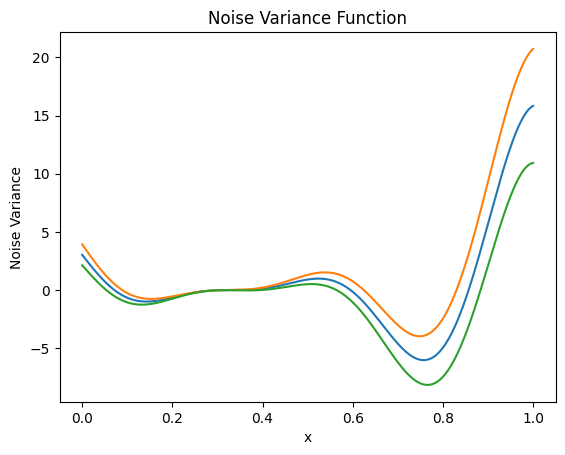

In [8]:
# Grid values
x_grid = np.linspace(0, 1, 1000)
f_grid = calculate_y_true(x_grid)
noise_variance = noise_var_fun(x_grid)

# Sampling plan
x_doe = np.linspace(0, 1, 9)
print(x_doe)

# Observations
# y_doe = noise_var_fun(x_doe)

# Plot points
plt.plot(x_grid, f_grid)
plt.plot(x_grid, f_grid + noise_variance)
plt.plot(x_grid, f_grid - noise_variance)
# plt.scatter(x_doe, y_doe)
plt.xlabel('x')
plt.ylabel('Noise Variance')
plt.title('Noise Variance Function')
plt.show()

# Noisy function

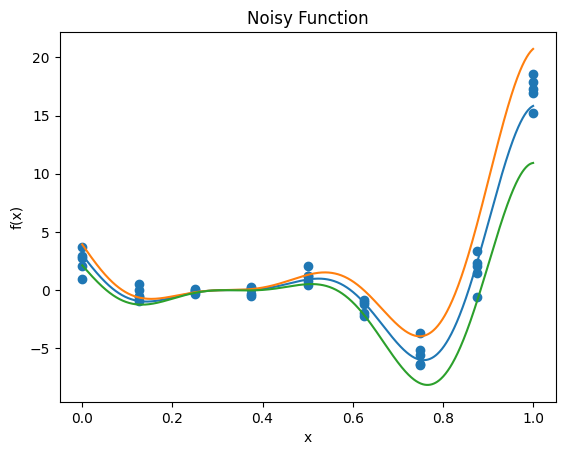

In [9]:
# Initialization
x_doe5, y_doe5, noise5 = [], [], []
num_reps = 5

# Loop over the original x_doe array
for i in range(len(x_doe)):
  for _ in range(num_reps):
    # Simulate noise
    noise = noise_var_fun(x_doe[i])
    y = calculate_y_noisy(x_doe[i])
    # Append values
    x_doe5.append(x_doe[i])
    y_doe5.append(y)
    noise5.append(noise)

# Convert the lists to NumPy arrays for efficient numerical computation
x_doe5 = np.array(x_doe5)
y_doe5 = np.array(y_doe5)
noise5 = np.array(noise5)

# Check plot
plt.plot(x_grid, f_grid)
plt.plot(x_grid, f_grid + noise_variance)
plt.plot(x_grid, f_grid - noise_variance)
plt.scatter(x_doe5, y_doe5)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Noisy Function')
plt.show()

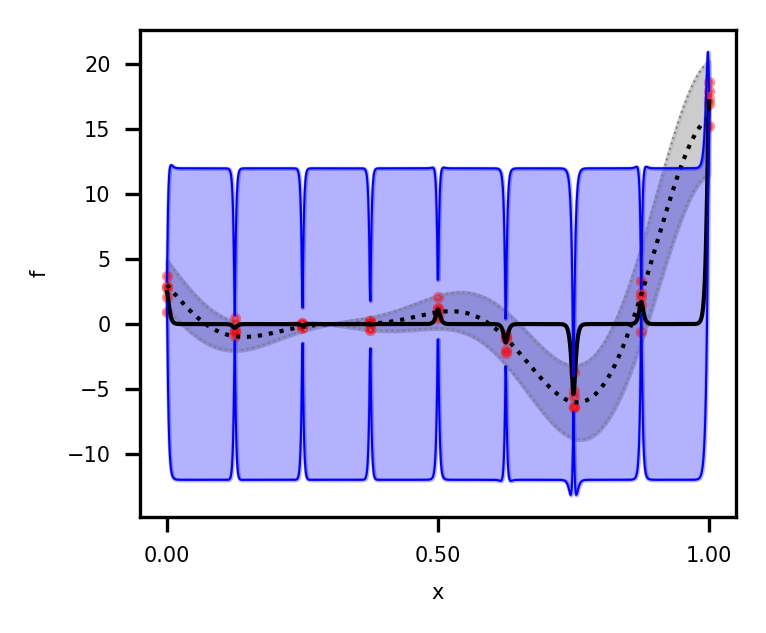

In [10]:
# Train vanilla GP
f_model = train_gp_model(x_doe5.reshape(-1,1), y_doe5.reshape(-1,1), k='m32')
f_mean, f_var = f_model.predict_f(x_grid.reshape(-1,1))
f_mean = f_mean.numpy()
f_var = f_var.numpy()

# Plot
gp_noisy_plot(x_grid, f_grid, f_mean, f_var, noise_variance, x_doe5, y_doe5)

In [11]:
# HGP
def gather_data(data, num_reps=num_reps):
  samples = int(len(data)/num_reps)
  mean, var = [], []
  for k in range(samples):
    j = num_reps*k
    mean.append(np.mean(data[j:j+num_reps]))
    var.append(np.var(data[j:j+num_reps]))
  return mean, var

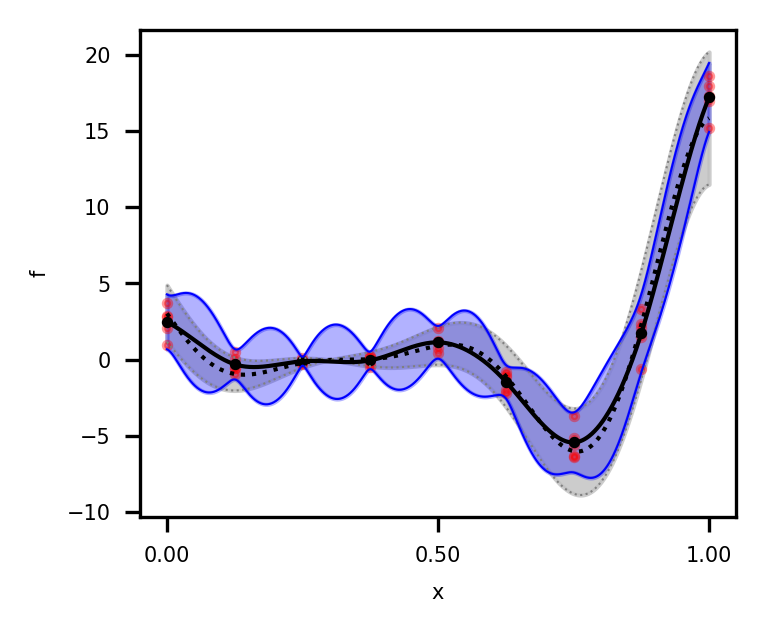

In [12]:
# Gather data
xmean, xvar = gather_data(x_doe5)
ymean, yvar = gather_data(y_doe5)

xmean = np.array(xmean)
xvar = np.array(xvar)
ymean = np.array(ymean)
yvar = np.array(yvar)

# GP of the y mean
ymean_model = train_gp2_model(xmean.reshape(-1,1), ymean.reshape(-1,1), k='m32', lambda_=1e-3)
ymean_mean, ymean_var = ymean_model.predict_f(x_grid.reshape(-1,1))
ymean_mean = np.array(ymean_mean)
ymean_var = np.array(ymean_var)

# GP of the y var
yvar_model = train_gp2_model(xmean.reshape(-1,1), yvar.reshape(-1,1), k='m32', lambda_=1e-3)
yvar_mean, yvar_var = yvar_model.predict_f(x_grid.reshape(-1,1))
yvar_mean = np.array(yvar_mean)
yvar_var = np.array(yvar_var)

# Plot
gp_noisy_plot(x_grid, f_grid, ymean_mean, ymean_var + yvar_mean + yvar_var, noise_variance, x_doe5, y_doe5)
plt.scatter(xmean, ymean, s=3, color='k')
plt.show()